In [1]:
# Importar las librerias
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing.image import load_img
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [221]:
# Obtener las imágenes de ISIC
!pip install git+https://github.com/ImageMarkup/isic-cli.git

  Cloning https://github.com/ImageMarkup/isic-cli.git to /private/var/folders/hy/zrllfrts39ngs0hg4l7nn93w0000gn/T/pip-req-build-f0tkjtp4
  Running command git clone --filter=blob:none --quiet https://github.com/ImageMarkup/isic-cli.git /private/var/folders/hy/zrllfrts39ngs0hg4l7nn93w0000gn/T/pip-req-build-f0tkjtp4
  Resolved https://github.com/ImageMarkup/isic-cli.git to commit af06f39821221d0d406ea9bb7c2328ec4232f966
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for isic-cli: filename=isic_cli-11.0.0-py3-none-any.whl size=30357 sha256=48cf6cbbc2a0f63d552e7981e726f89604d383753ddeae8a5e3d84df8d93aeb8
  Stored in directory: /private/var/folders/hy/zrllfrts39ngs0hg4l7nn93w0000gn/T/pip-ephem-wheel-cache-enlchb34/wheels/f0/0c/e6/a5ed22f71d7a51e80427565b0ebb573cbaded1834455aac0a7
Successfully built isic-cli


In [223]:
# Obtener los identificadores de los conjuntos de imágenes
!isic collection list

If you have been granted special permissions, logging in with `isic user login` might return more data.

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                      ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                  │ True   │ False  │ False  │ None            │
│ 404 │ Caio Falcão               │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test      │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training  │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test      │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training  │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017:           │ True   │ True   │ True   │ None            │
│     │ Validation                │        │        │        │                 │
│ 64

In [ ]:
'''
│ 67 │ Challenge 2018: Task 3: Test
│ 66 │ Challenge 2018: Task 3: Training
│ 73 │ Challenge 2018: Task 3: Validation
'''

In [3]:
# Carpetas de training
output_dir_training = '/Users/alvarosalgado/Documents/ML/isic_images_training'
os.makedirs(output_dir_training, exist_ok=True)
# Carpetas de validation
output_dir_validation = '/Users/alvarosalgado/Documents/ML/isic_images_validation'
os.makedirs(output_dir_validation, exist_ok=True)
# Carpetas de test
output_dir_test = '/Users/alvarosalgado/Documents/ML/isic_images_test'
os.makedirs(output_dir_test, exist_ok=True)


In [229]:
# Descargar las imágenes de training y metadata
!isic image download --collections 66 '/Users/alvarosalgado/Documents/ML/isic_images_training'

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 10,015 images to /Users/alvarosalgado/Documents/ML/isic_images_training/.
Successfully wrote 10,015 metadata records to /Users/alvarosalgado/Documents/ML/isic_images_training/metadata.csv.
Successfully wrote attributions to /Users/alvarosalgado/Documents/ML/isic_images_training/attribution.txt.
Successfully wrote 1 license(s) to /Users/alvarosalgado/Documents/ML/isic_images_training/licenses.


In [231]:
# Descargar imágenes de validación y metadata
!isic image download --collections 73 '/Users/alvarosalgado/Documents/ML/isic_images_validation'

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 193 images to /Users/alvarosalgado/Documents/ML/isic_images_validation/.
Successfully wrote 193 metadata records to /Users/alvarosalgado/Documents/ML/isic_images_validation/metadata.csv.
Successfully wrote attributions to /Users/alvarosalgado/Documents/ML/isic_images_validation/attribution.txt.
Successfully wrote 1 license(s) to /Users/alvarosalgado/Documents/ML/isic_images_validation/licenses.


In [234]:
# Descargar imágenes de test y metadata
!isic image download --collections 67 '/Users/alvarosalgado/Documents/ML/isic_images_test'

If you have been granted special permissions, logging in with `isic user login` might return more data.


Successfully downloaded 1,512 images to /Users/alvarosalgado/Documents/ML/isic_images_test/.
Successfully wrote 1,512 metadata records to /Users/alvarosalgado/Documents/ML/isic_images_test/metadata.csv.
Successfully wrote attributions to /Users/alvarosalgado/Documents/ML/isic_images_test/attribution.txt.
Successfully wrote 1 license(s) to /Users/alvarosalgado/Documents/ML/isic_images_test/licenses.


In [5]:
# Rutas a las carpetas e información de etiquetas
train_dir = output_dir_training
val_dir = output_dir_validation
test_dir = output_dir_test

train_labels = pd.read_csv("/Users/alvarosalgado/Documents/ML/isic_images_training/metadata.csv")  # Archivo CSV con etiquetas
val_labels = pd.read_csv("/Users/alvarosalgado/Documents/ML/isic_images_validation/metadata.csv")      # Archivo CSV con etiquetas
test_labels = pd.read_csv("/Users/alvarosalgado/Documents/ML/isic_images_test/metadata.csv")    # Archivo CSV con etiquetas

# Utilizar solo el diagnóstico
train_labels = train_labels[['isic_id', 'diagnosis']]
val_labels = val_labels[['isic_id', 'diagnosis']]
test_labels = test_labels[['isic_id', 'diagnosis']]

# Agregar la extensión jpg
train_labels['isic_id'] = train_labels['isic_id'] + '.jpg'
val_labels['isic_id'] = val_labels['isic_id'] + '.jpg'
test_labels['isic_id'] = test_labels['isic_id'] + '.jpg'

In [7]:
print('Diagnósticos',train_labels.diagnosis.unique())
print(train_labels.diagnosis.unique().shape)

Diagnósticos ['nevus' 'pigmented benign keratosis' 'melanoma' 'basal cell carcinoma'
 'vascular lesion' 'dermatofibroma' 'squamous cell carcinoma'
 'actinic keratosis']
(8,)


In [9]:
print('Diagnósticos', val_labels.diagnosis.unique())
print(val_labels.diagnosis.unique().shape)

Diagnósticos ['basal cell carcinoma' 'nevus' 'pigmented benign keratosis'
 'vascular lesion' 'melanoma' 'squamous cell carcinoma' 'dermatofibroma']
(7,)


In [11]:
print('Diagnósticos',test_labels.diagnosis.unique())
print(test_labels.diagnosis.unique().shape)

Diagnósticos ['basal cell carcinoma' 'pigmented benign keratosis' 'actinic keratosis'
 'nevus' 'melanoma' 'dermatofibroma' 'vascular lesion'
 'squamous cell carcinoma']
(8,)


In [13]:
test_labels[test_labels['diagnosis'] == 'actinic keratosis'].shape

(19, 2)

In [15]:
train_labels[train_labels['diagnosis'] == 'actinic keratosis'].shape

(130, 2)

In [17]:
# Cambiar el nombre de actinic keratosis a squamous cell carcinoma
train_labels['diagnosis'] = train_labels['diagnosis'].replace('actinic keratosis', 'squamous cell carcinoma')
test_labels['diagnosis'] = test_labels['diagnosis'].replace('actinic keratosis', 'squamous cell carcinoma')


In [19]:
# Comprobar los cambios
print('Diagnósticos',train_labels.diagnosis.unique())
print(train_labels.diagnosis.unique().shape)

Diagnósticos ['nevus' 'pigmented benign keratosis' 'melanoma' 'basal cell carcinoma'
 'vascular lesion' 'dermatofibroma' 'squamous cell carcinoma']
(7,)


In [21]:
print('Diagnósticos',test_labels.diagnosis.unique())
print(test_labels.diagnosis.unique().shape)

Diagnósticos ['basal cell carcinoma' 'pigmented benign keratosis'
 'squamous cell carcinoma' 'nevus' 'melanoma' 'dermatofibroma'
 'vascular lesion']
(7,)


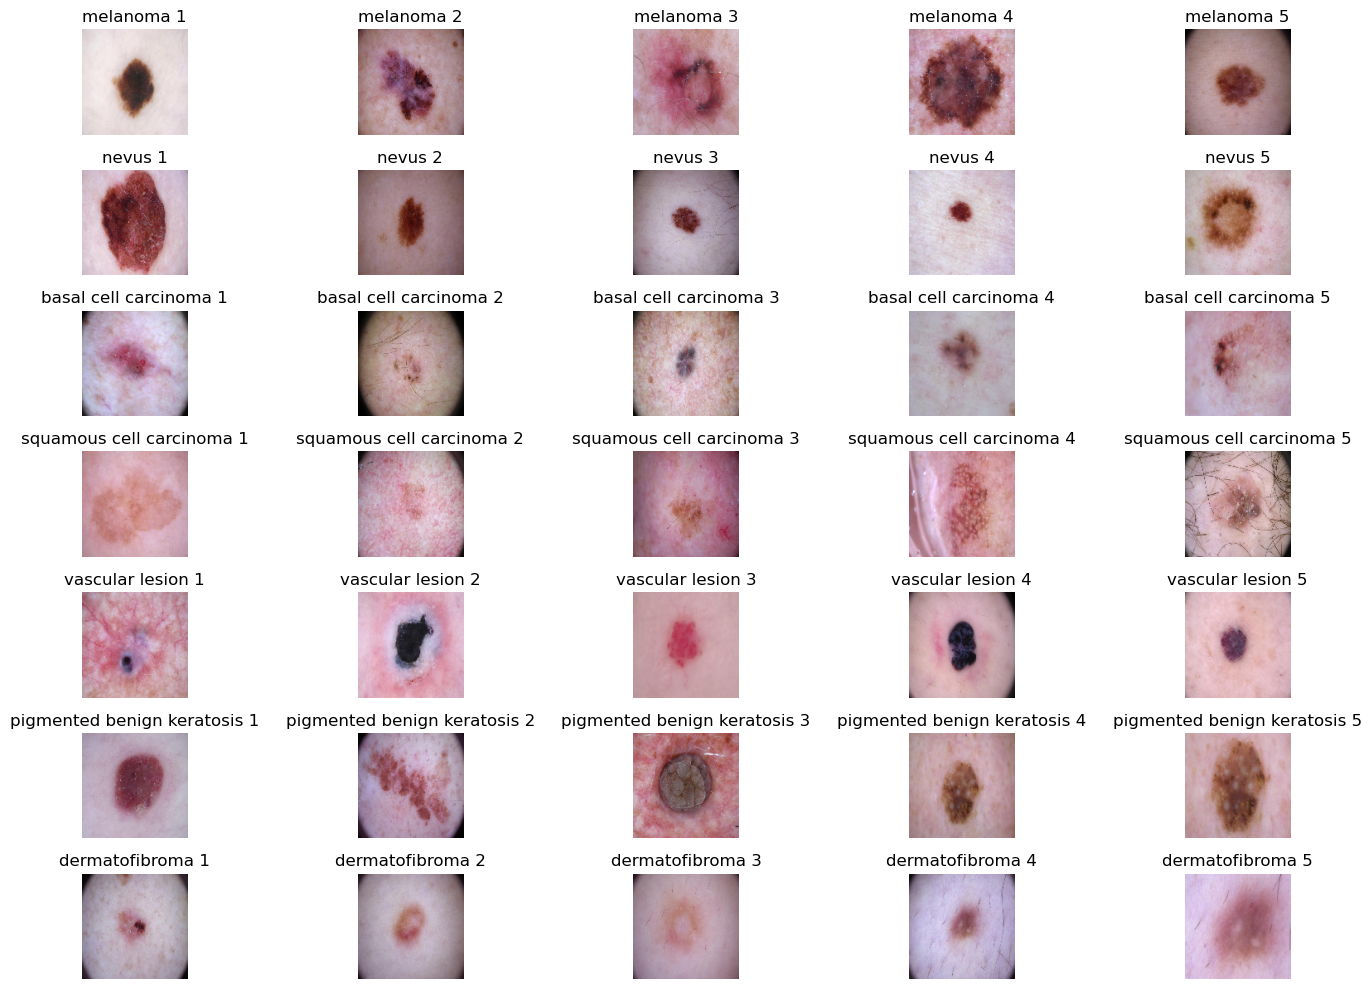

In [462]:
# Cargar el archivo de metadatos
metadata = train_labels

# Definir las categorías de diagnóstico
categories = ['melanoma', 'nevus', 'basal cell carcinoma', 'squamous cell carcinoma',
              'vascular lesion', 'pigmented benign keratosis', 'dermatofibroma']

# Número de imágenes a mostrar por clase
num_images_to_show = 5

# Crear una figura para las imágenes
plt.figure(figsize=(15, 10))

# Mostrar 5 imágenes de cada categoría
for i, category in enumerate(categories):
    # Filtrar las imágenes por la categoría actual
    category_images = metadata[metadata['diagnosis'] == category].head(num_images_to_show)
    
    for j, (index, row) in enumerate(category_images.iterrows()):
        # Cargar y mostrar la imagen
        img_path = os.path.join(train_dir, row['isic_id'])
        img = load_img(img_path, target_size=(128, 128))  # Redimensionar a 128x128 píxeles
        plt.subplot(len(categories), num_images_to_show, i * num_images_to_show + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{category} {j+1}')
        
plt.tight_layout()
plt.savefig('/Users/alvarosalgado/Documents/ML/lesiones_cutaneas.png', dpi=300)  # dpi=300 para alta calidad
plt.show()


In [352]:
# Revisar balanceo de los diagnósticos 
label_counts = train_labels['diagnosis'].value_counts()
print("Conteo de etiquetas:", label_counts)

Conteo de etiquetas: diagnosis
nevus                         6705
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        327
vascular lesion                142
dermatofibroma                 115
Name: count, dtype: int64


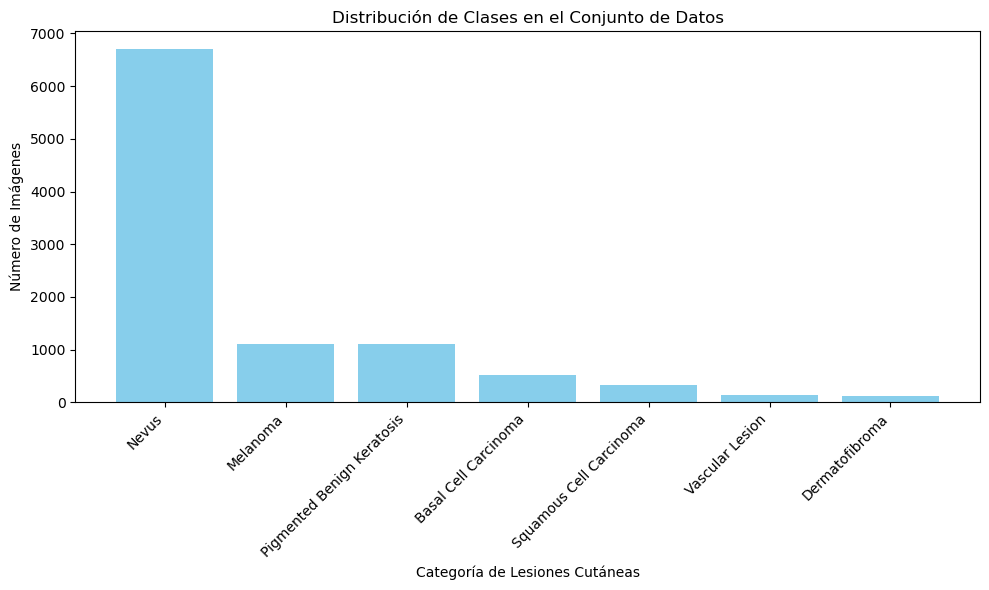

In [674]:
# Datos de las clases y sus conteos
labels = ['Nevus', 'Melanoma', 'Pigmented Benign Keratosis', 'Basal Cell Carcinoma', 
          'Squamous Cell Carcinoma', 'Vascular Lesion', 'Dermatofibroma']
counts = [6705, 1113, 1099, 514, 327, 142, 115]

# Crear la gráfica
plt.figure(figsize=(10,6))
plt.bar(labels, counts, color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Datos')
plt.xlabel('Categoría de Lesiones Cutáneas')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/Users/alvarosalgado/Documents/ML/balance clases.png', dpi=300)  # dpi=300 para alta calidad
# Mostrar la gráfica
plt.show()

In [394]:
# Ruta de la carpeta de imágenes
image_folder = output_dir_training

# Leer el archivo CSV con las etiquetas
labels_df = train_labels

# Agregar la columna de rutas completas
labels_df['image_path'] = labels_df['isic_id'].apply(lambda x: os.path.join(image_folder, x))

# Revisar el DataFrame final
print(labels_df.head())

            isic_id                   diagnosis  \
0  ISIC_0034320.jpg                       nevus   
1  ISIC_0034319.jpg                       nevus   
2  ISIC_0034318.jpg  pigmented benign keratosis   
3  ISIC_0034317.jpg                    melanoma   
4  ISIC_0034316.jpg                    melanoma   

                                          image_path  
0  /Users/alvarosalgado/Documents/ML/isic_images_...  
1  /Users/alvarosalgado/Documents/ML/isic_images_...  
2  /Users/alvarosalgado/Documents/ML/isic_images_...  
3  /Users/alvarosalgado/Documents/ML/isic_images_...  
4  /Users/alvarosalgado/Documents/ML/isic_images_...  


In [624]:
# Definir las columnas de interés
X = labels_df[['image_path']]  # Rutas de las imágenes
y = labels_df['diagnosis']  # Etiquetas de diagnóstico

# Aplicar sobremuestreo
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Crear un nuevo DataFrame equilibrado
balanced_df = X_resampled.copy()
balanced_df['diagnosis'] = y_resampled

# Mezcla los datos
balanced_df = shuffle(balanced_df, random_state=42)

# Verifica la distribución
print(balanced_df['diagnosis'].value_counts())

diagnosis
melanoma                      6705
squamous cell carcinoma       6705
dermatofibroma                6705
pigmented benign keratosis    6705
vascular lesion               6705
nevus                         6705
basal cell carcinoma          6705
Name: count, dtype: int64


In [75]:
balanced_df.shape

(46935, 2)

In [634]:
# Configuración del generador con aumentaciones para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalizacióna
    rotation_range=30,        # Rotación aleatoria
    width_shift_range=0.2,    # Desplazamiento horizontal
    height_shift_range=0.2,   # Desplazamiento vertical
    shear_range=0.2,          # Transformación de corte
    zoom_range=0.2,           # Zoom
    horizontal_flip=True,      # Inversión horizontal
    fill_mode='nearest'         # Relleno de los pixeles generados por las transformaciones

)
batch_size = 64
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Solo normalización para validación y prueba


# Generador para el conjunto de entrenamiento
train_gen = train_datagen.flow_from_dataframe(
    dataframe=balanced_df,
    directory=train_dir,
    x_col='image_path',         # Nombre del archivo de la imagen
    y_col='diagnosis',            # Etiqueta correspondiente
    target_size=(128, 128),   # Tamaño de las imágenes
    batch_size=batch_size,            # Tamaño del lote
    class_mode='categorical',  # Clasificación multiclase
)



# Generador para el conjunto de validación
val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=val_dir,
    x_col='isic_id',
    y_col='diagnosis',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generador para el conjunto de prueba
test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=test_dir,
    x_col='isic_id',
    y_col='diagnosis',
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Mantén el orden para evaluación consistente
)
print("Clases detectadas:", train_gen.class_indices)

Found 46935 validated image filenames belonging to 7 classes.
Found 193 validated image filenames belonging to 7 classes.
Found 1512 validated image filenames belonging to 7 classes.
Clases detectadas: {'basal cell carcinoma': 0, 'dermatofibroma': 1, 'melanoma': 2, 'nevus': 3, 'pigmented benign keratosis': 4, 'squamous cell carcinoma': 5, 'vascular lesion': 6}


In [510]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Obtener las clases de tu conjunto de entrenamiento
y_train = train_gen.classes  # Esto contiene las clases de cada imagen en el conjunto de entrenamiento

# Calcular los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Crear un diccionario con los pesos por clase
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Pesos de las clases:", class_weight_dict)

Pesos de las clases: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


In [570]:
# Verificar el primer lote de datos
images, labels = next(train_gen)
print(f'Imagenes: {images.shape}')
print(f'Labels: {labels.shape}')

Imagenes: (32, 128, 128, 3)
Labels: (32, 7)


In [514]:
def custom_generator(generator, class_weights):
    while True:
        images, labels = next(generator)  # Obtener imágenes y etiquetas
        # Calcular los pesos para cada imagen en el lote
        weights = np.array([class_weights[np.argmax(label)] for label in labels])  # Asumimos que 'labels' es one-hot
        yield images, labels, weights  # Devuelve imágenes, etiquetas y pesos de clase
# Usando el generador personalizado
train_gen_with_weights = custom_generator(train_gen, class_weight_dict)

In [516]:
# Probar el generador
images, labels, weights = next(train_gen_with_weights)

# Imprimir las formas de las salidas
print(f"Imágenes: {images.shape}")
print(f"Etiquetas: {labels.shape}")
print(f"Pesos: {weights.shape}")

Imágenes: (16, 28, 28, 3)
Etiquetas: (16, 7)
Pesos: (16,)


In [682]:
# Construcción de la CNN
model = Sequential([
    # Bloque inicial - IMAGEN -> CONV1
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    
    # CONV2
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    
    # CONV3
    MaxPooling2D(pool_size=(2, 2)),  # Reduce a 13x13x32
    BatchNormalization(),
    
    # CONV4
    Conv2D(64, (3, 3), activation='relu'),  # 11x11x64
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),  # Reduce a 6x6x64
    
    # Aplanar
    Flatten(),
    
    # Capas densas
    Dense(512, activation='relu'),  # FC5
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu'),    # FC6
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),    # FC7
    BatchNormalization(),
    
    # Capa de salida
    Dense(7, activation='softmax')   # Salida con 7 clases
])

# Compilación del modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_90 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_210         │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 126, 126, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_211         │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_212         │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_213         │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_214         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_215         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_216         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,553,447 (112.74 MB)

 Trainable params: 29,551,943 (112.73 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [684]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
]

# Entrenamiento del modelo con los callbacks
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 481s 654ms/step - accuracy: 0.4381 - loss: 1.4845 - val_accuracy: 0.5699 - val_loss: 1.1189 - learning_rate: 0.0010
Epoch 2/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 542s 738ms/step - accuracy: 0.6012 - loss: 1.0480 - val_accuracy: 0.4767 - val_loss: 1.1943 - learning_rate: 0.0010
Epoch 3/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 563s 767ms/step - accuracy: 0.6416 - loss: 0.9392 - val_accuracy: 0.6528 - val_loss: 0.8448 - learning_rate: 0.0010
Epoch 4/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 554s 754ms/step - accuracy: 0.6816 - loss: 0.8530 - val_accuracy: 0.6632 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 5/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 557s 759ms/step - accuracy: 0.6955 - loss: 0.8113 - val_accuracy: 0.7617 - val_loss: 0.6672 - learning_rate: 0.0010
Epoch 6/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 577s 786ms/step - accuracy: 0.7257 - loss: 0.7383 - val_accuracy: 0.6062 - val_loss: 1.0546 - learning_rate: 0.0010
Epoch 7/10
734/734 ━━━━━━━━━━━━━━━━━━━━ 579s 788ms/step - accura

In [604]:
# Guardar el modelo
#model.save('modelo_isic_10epoch_64batch_128x128.keras')

In [688]:
from tensorflow.keras.models import load_model
# Evaluar el modelo en el conjunto de prueba
model = load_model('/Users/alvarosalgado/Documents/ML/modelo_isic_10epoch_64batch_128x128.keras')
loss, accuracy = model.evaluate(test_gen, verbose=2)


24/24 - 3s - 121ms/step - accuracy: 0.6376 - loss: 0.9612


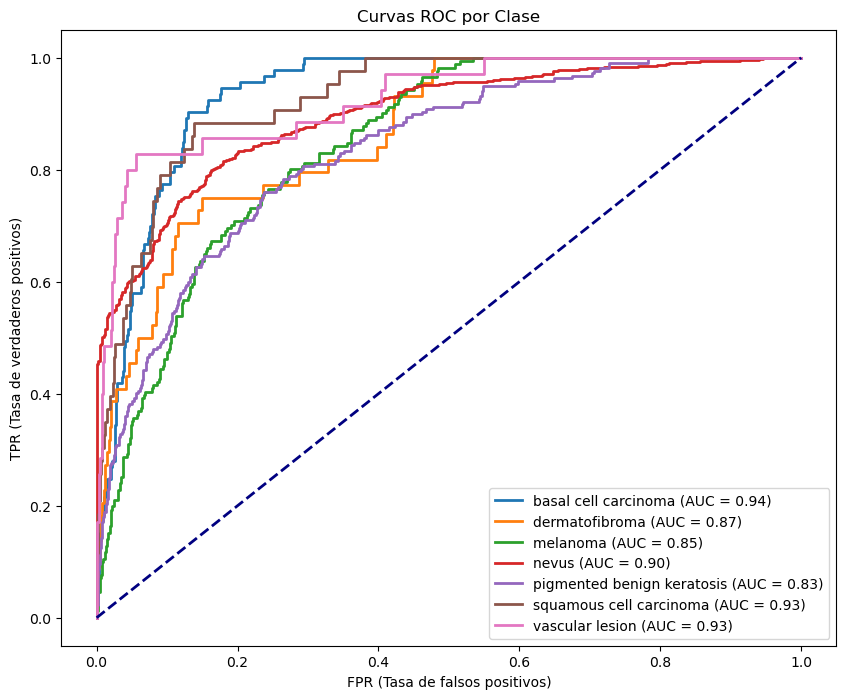

In [668]:
# Obtener las probabilidades predichas para cada clase
y_pred_prob = model.predict(test_gen, steps=len(test_gen), verbose=0)

# Binarizar las etiquetas verdaderas (las etiquetas deben estar en formato one-hot)
y_true = test_gen.classes
y_true_bin = label_binarize(y_true, classes=list(train_gen.class_indices.values()))  # Binarizar las clases

# Obtener los nombres de las clases desde train_gen
class_names = {v: k for k, v in train_gen.class_indices.items()}  # Invertir el diccionario para obtener los nombres

# Inicializar la figura para las curvas ROC
plt.figure(figsize=(10, 8))

# Inicializar las variables para las curvas ROC y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Generar las curvas ROC para cada clase
for i in range(len(class_names)):  # Iterar sobre las clases disponibles
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar la curva ROC para cada clase con el nombre de la clase
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Graficar la línea diagonal (random guess)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Agregar detalles a la gráfica
plt.title('Curvas ROC por Clase')
plt.xlabel('FPR (Tasa de falsos positivos)')
plt.ylabel('TPR (Tasa de verdaderos positivos)')
plt.legend(loc='lower right')

# Mostrar la gráfica
plt.savefig('/Users/alvarosalgado/Documents/ML/curvas ROC.png', dpi=300)  # dpi=300 para alta calidad
plt.show()

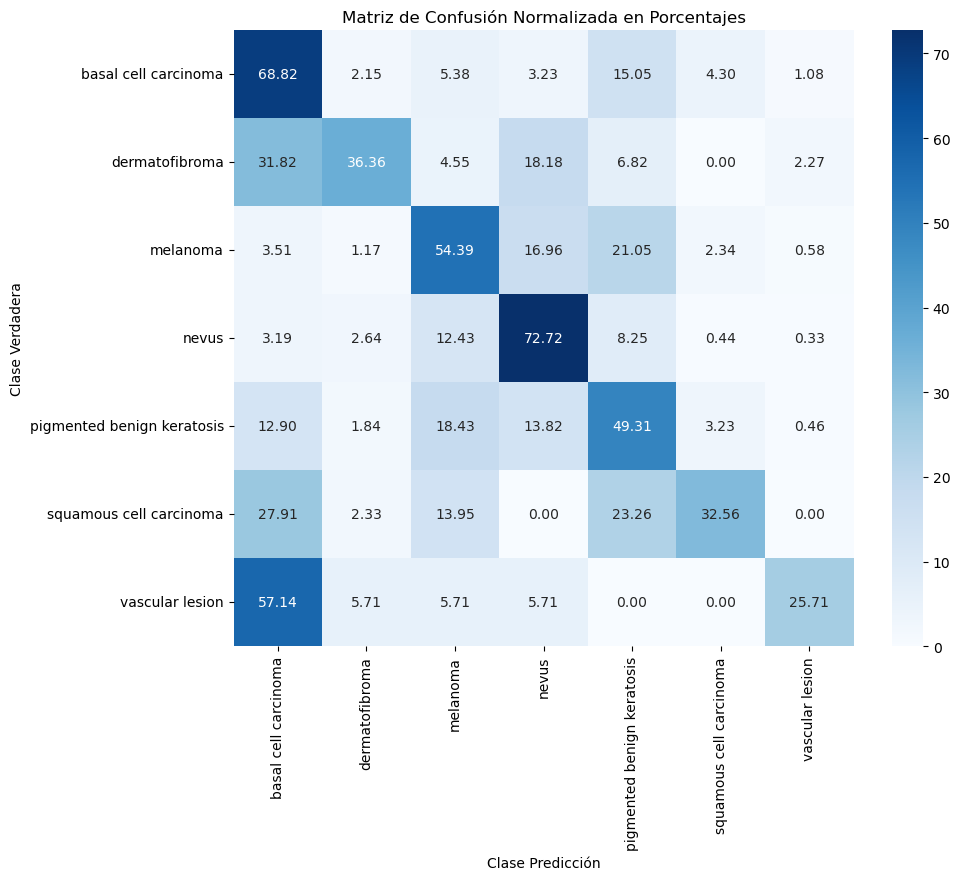

In [670]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas

# Obtener las etiquetas verdaderas
y_true = test_gen.classes

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Normalizar la matriz de confusión en porcentajes
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Nombres de las clases
class_names = list(test_gen.class_indices.keys())

# Visualizar la matriz de confusión normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión Normalizada en Porcentajes')
plt.xlabel('Clase Predicción')
plt.ylabel('Clase Verdadera')
plt.savefig('/Users/alvarosalgado/Documents/ML/cm.png', dpi=300)  # dpi=300 para alta calidad
plt.show()

In [678]:
# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(test_gen, steps=len(test_gen), verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Obtener las clases predichas

# Obtener las etiquetas verdaderas
y_true = test_gen.classes

# Calcular las métricas para el problema multiclase (usando "macro" promedio)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# También se puede calcular con "weighted" o "micro" si se prefiere, por ejemplo:
# precision = precision_score(y_true, y_pred_classes, average='weighted')
# recall = recall_score(y_true, y_pred_classes, average='weighted')
# f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Mostrar los resultados
print(f'Exactitud (Accuracy): {accuracy:.4f}')
print(f'Precisión (Precision): {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Exactitud (Accuracy): 0.6171
Precisión (Precision): 0.6732
Recall: 0.6171
F1 Score: 0.6324


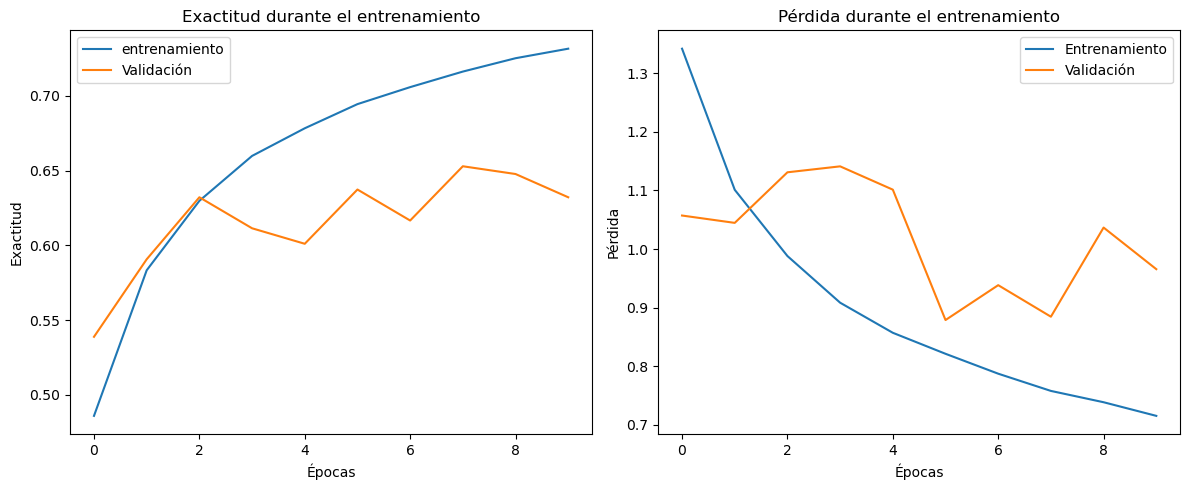

In [654]:
# Obtener el historial de entrenamiento
history_dict = history.history

# Crear gráficas para la exactitud
plt.figure(figsize=(12, 5))

# Exactitud de entrenamiento vs. validación
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='entrenamiento')
plt.plot(history_dict['val_accuracy'], label='Validación')
plt.title('Exactitud durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida de entrenamiento vs. validación
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Entrenamiento')
plt.plot(history_dict['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [656]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
# Predicciones del modelo
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Si es clasificación multiclase

# Etiquetas verdaderas
y_true = test_gen.classes  # Suponiendo que 'test_gen' es el generador de datos
# Calcular múltiples métricas en una sola línea
precision, recall, f1, accuracy, conf_matrix = (
    precision_score(y_true, y_pred_classes, average='weighted'),
    recall_score(y_true, y_pred_classes, average='weighted'),
    f1_score(y_true, y_pred_classes, average='weighted'),
    accuracy_score(y_true, y_pred_classes),
    confusion_matrix(y_true, y_pred_classes)
)

# Mostrar los resultados
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step
Precision: 0.7021
Recall: 0.6376
F1-Score: 0.6572
Accuracy: 0.6376
Confusion Matrix:
[[ 64   2   5   3  14   4   1]
 [ 14  16   2   8   3   0   1]
 [  6   2  93  29  36   4   1]
 [ 29  24 113 661  75   4   3]
 [ 28   4  40  30 107   7   1]
 [ 12   1   6   0  10  14   0]
 [ 20   2   2   2   0   0   9]]
